**Sample ID**: CM195_base


**Query**: Has it rained today? If not, please run the sprinklers in the front yard and the backyard.


**DB Type**: Base Case


**Case Description**: Initially the footage from the front yard camera shows that it has not rained recently. Based on this observation, proceed to turn on the "Front yard Sprinkler System" and "Back yard Sprinkler System" sprinklers in both the front and back yards.

**Global/Context Variables:**

**APIs:**
- home_assistant
- sdm

# Set Up

## Download relevant files

In [ ]:
import io
import os
import sys
import zipfile
import shutil
import re
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload

VERSION = "0.1.4"  # Pass the version of the API
CONTENT_DIR = '/content'
APIS_DIR = os.path.join(CONTENT_DIR, 'APIs')
DBS_DIR = os.path.join(CONTENT_DIR, 'DBs')
SCRIPTS_DIR = os.path.join(CONTENT_DIR, 'Scripts')
FC_DIR = os.path.join(CONTENT_DIR, 'Schemas')
ZIP_PATH = os.path.join(CONTENT_DIR, f'APIs_V{VERSION}.zip')

APIS_FOLDER_ID = '1QpkAZxXhVFzIbm8qPGPRP1YqXEvJ4uD4'
ITEMS_TO_EXTRACT = ['APIs/', 'DBs/', 'Scripts/', 'Schemas/']

# Cleanup
for path in [APIS_DIR, DBS_DIR, SCRIPTS_DIR, FC_DIR, ZIP_PATH]:
    if os.path.exists(path):
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.remove(path)

# Auth
auth.authenticate_user()
drive_service = build('drive', 'v3')

def download_drive_file(service, file_id, output_path, file_name=None, show_progress=True):
    request = service.files().get_media(fileId=file_id)
    with io.FileIO(output_path, 'wb') as fh:
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()
            if show_progress:
                print(f"Download progress: {int(status.progress() * 100)}%")

print(f"Searching for APIs zip file with version {VERSION} in folder: {APIS_FOLDER_ID}...")
apis_file_id = None
try:
    query = f"'{APIS_FOLDER_ID}' in parents and trashed=false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    for file in results.get('files', []):
        if file['name'].lower() == f'apis_v{VERSION.lower()}.zip':
            apis_file_id = file['id']
            print(f"Found: {file['name']} (ID: {apis_file_id})")
            break
except Exception as e:
    print(f"Error listing files: {e}")

if not apis_file_id:
    sys.exit(f"❌ APIs zip V{VERSION} not found.")

print(f"Downloading APIs zip {apis_file_id}...")
download_drive_file(drive_service, apis_file_id, ZIP_PATH)

print(f"Extracting {ZIP_PATH}...")
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    for member in zip_ref.namelist():
        if any(member.startswith(p) for p in ITEMS_TO_EXTRACT):
            zip_ref.extract(member, CONTENT_DIR)

os.remove(ZIP_PATH)

if os.path.exists(APIS_DIR):
    sys.path.append(APIS_DIR)

for p in [APIS_DIR, DBS_DIR, SCRIPTS_DIR]:
    print(f"{'✅' if os.path.exists(p) else '❌'} {p}")

# PWS: Copy pws_image_data folder in /content/pws_image_data
print(f"\nDownloading all files from pws_images_data Drive folder.")
IMAGES_ZIP_ID = '1MlgE9LnFA221ARh9l4nbF1yGc215KDN_'
IMAGES_ZIP_PATH = os.path.join(CONTENT_DIR, 'pws_images_data.zip')
download_drive_file(drive_service, IMAGES_ZIP_ID, IMAGES_ZIP_PATH, file_name='pws_images_data.zip')

print(f"Extracting images from {IMAGES_ZIP_PATH} to {CONTENT_DIR}...")
try:
    with zipfile.ZipFile(IMAGES_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(CONTENT_DIR)

except zipfile.BadZipFile:
    print(f"Error: The downloaded file at {IMAGES_ZIP_PATH} is not a valid zip file.")
    sys.exit("Invalid zip file downloaded.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")
    sys.exit("Extraction failed.")

if os.path.exists(IMAGES_ZIP_PATH):
    os.remove(IMAGES_ZIP_PATH)

Searching for APIs zip file with version 0.0.6 in folder: 1QpkAZxXhVFzIbm8qPGPRP1YqXEvJ4uD4...
Found matching file: APIs_V0.0.6.zip (ID: 1LZ9uyD9xU9U32zr4fztMXiWmIhfJtdj-)
Download progress: 100%
Extracting specific items from /content/APIs_V0.0.6.zip to /content...
Searching for Scenario DB file in folder: 1swWdYMlRkxgEFEqSRUIyZ9JZGGo21nOl...
Found matching file: CM195_base_DB.json (ID: 15RQ0IbEDA-pcQdj4FnS4UgaB7IrfGOgZ)
Download progress: 100%
Searching for Image Map file in folder: 1swWdYMlRkxgEFEqSRUIyZ9JZGGo21nOl...
Found matching file: CM195_base_ImageMap.json (ID: 1sSMychS1AyGhdQyq6RY0o3uz5wrkRLhV)
Download progress: 100%
Searching for Images folder in folder: 1swWdYMlRkxgEFEqSRUIyZ9JZGGo21nOl...
Found matching folder: CM195_base_Images (ID: 1HbyYhXN1FRJ8a6EUCMXp_m6Y2iywXHXF)
Download complete!

Verifying extracted items:
✅ /content/APIs is present.
✅ /content/DBs is present.
✅ /content/Scripts is present.
✅ /content/scenario_db.json is present.
✅ /content/image_map.json is pres

## Install Dependencies and Clone Repositories

In [ ]:
!pip install uv
!uv pip install -r /content/APIs/requirements.txt
!uv pip install jsonpath_ng

## Import APIs and initiate DBs

In [ ]:
scenario_db = {'environment': {'home_assistant': {'devices': {'LIGHT_001': {'attributes': {'brightness': 1.0,
                                                                             'company': 'Crompton',
                                                                             'model': '4Ft.22W',
                                                                             'serial_number': 'C907890',
                                                                             'state': 'On',
                                                                             'supports_color': 'No'},
                                                              'environment': 'indoor',
                                                              'name': 'Kitchen '
                                                                      'Light',
                                                              'type': 'Light'},
                                                'LIGHT_002': {'attributes': {'brightness': 1.0,
                                                                             'company': 'Crompton',
                                                                             'model': '4Ft.22W',
                                                                             'serial_number': 'C847116',
                                                                             'state': 'On',
                                                                             'supports_color': 'No'},
                                                              'environment': 'indoor',
                                                              'name': 'Tims '
                                                                      'room '
                                                                      'light',
                                                              'type': 'Light'},
                                                'LIGHT_003': {'attributes': {'brightness': 1.0,
                                                                             'company': 'Crompton',
                                                                             'model': '4Ft.22W',
                                                                             'serial_number': 'C847116',
                                                                             'state': 'On',
                                                                             'supports_color': 'No'},
                                                              'environment': 'outdoor',
                                                              'name': 'driveway '
                                                                      'light',
                                                              'type': 'Light'},
                                                'SPRINKLER_001': {'attributes': {'company': 'Hunter',
                                                                                 'mode': 'rotate-spray',
                                                                                 'model': 'ProSpray-TM '
                                                                                          'PRS40',
                                                                                 'serial_number': 'PRS40_366792',
                                                                                 'speed': '3',
                                                                                 'state': 'Off'},
                                                                  'name': 'Front '
                                                                          'yard '
                                                                          'Sprinkler '
                                                                          'System',
                                                                  'type': 'Sprinkler'},
                                                'SPRINKLER_002': {'attributes': {'company': 'Rain '
                                                                                            'Bird',
                                                                                 'mode': 'fixed-spray',
                                                                                 'model': '1804 '
                                                                                          'Dual '
                                                                                          'Spray',
                                                                                 'serial_number': 'RB1804_928374',
                                                                                 'speed': '3',
                                                                                 'state': 'Off'},
                                                                  'name': 'Back '
                                                                          'yard '
                                                                          'Sprinkler '
                                                                          'System',
                                                                  'type': 'Sprinkler'},
                                                'TV_001': {'attributes': {'brightness': 70,
                                                                          'company': 'Samsung',
                                                                          'is_muted': 'No',
                                                                          'model': '1.63 '
                                                                                   'm '
                                                                                   '(65) '
                                                                                   'QN900F '
                                                                                   'Neo '
                                                                                   'QLED '
                                                                                   '8K '
                                                                                   'Smart '
                                                                                   'TV',
                                                                          'serial_number': 'QN65Q800TAFXZA',
                                                                          'state': 'On',
                                                                          'volume': 65},
                                                           'name': 'Samsung '
                                                                   'Smart TV - '
                                                                   'Living '
                                                                   'Room',
                                                           'type': 'Television'},
                                                'WIFI_001': {'attributes': {'company': 'Netgear',
                                                                            'max_speed': 'Up '
                                                                                         'to '
                                                                                         '6 '
                                                                                         'Gbps',
                                                                            'model': 'Nighthawk '
                                                                                     'AX12 '
                                                                                     '(RAX120)',
                                                                            'security_protocol': 'WPA3-Personal',
                                                                            'serial_number': 'QN35Q800TAFXZA',
                                                                            'state': 'On',
                                                                            'wifi_standard': 'Wi-Fi '
                                                                                             '6 '
                                                                                             '(802.11ax)'},
                                                             'name': 'Vodafone-1234C',
                                                             'type': 'wifi'}}},
                 'sdm': {'devices': {'CAM_001': {'attributes': {'company': 'Google',
                                                                'model': 'Google '
                                                                         'Nest '
                                                                         'Cam '
                                                                         'Indoor',
                                                                'parent': 'enterprises/house-system-161820/structures/STRCT_INDOOR/place/BROOK_ROOM',
                                                                'serial_number': 'GN-I-294458',
                                                                'state': 'On'},
                                                 'name': 'Brooks Camera',
                                                 'type': 'Camera'},
                                     'CAM_002': {'attributes': {'company': 'Google',
                                                                'model': 'Google '
                                                                         'Nest '
                                                                         'Cam '
                                                                         'Indoor',
                                                                'parent': 'enterprises/house-system-161820/structures/STRCT_INDOOR/place/KITCHEN',
                                                                'serial_number': 'GN-I-162271',
                                                                'state': 'On'},
                                                 'name': 'Kitchen Camera',
                                                 'type': 'Camera'},
                                     'CAM_003': {'attributes': {'company': 'Google',
                                                                'model': 'Google '
                                                                         'Nest '
                                                                         'Cam '
                                                                         'Outdoor',
                                                                'parent': 'enterprises/house-system-161820/structures/STRCT_OUTDOOR/place/Outdoor',
                                                                'serial_number': 'GN-O-261515',
                                                                'state': 'On'},
                                                 'name': 'Outdoor Cam',
                                                 'type': 'Camera'}},
                         'structures': [{'name': 'enterprises/house-system-161820/structures/STRCT_OUTDOOR',
                                         'traits': {'sdm.structures.traits.Info': {'customName': 'MyHome '
                                                                                                 '- '
                                                                                                 'Outdoors'}}},
                                        {'name': 'enterprises/house-system-161820/structures/STRCT_INDOOR',
                                         'traits': {'sdm.structures.traits.Info': {'customName': 'MyHome '
                                                                                                 '- '
                                                                                                 'Indoors'}}}]}},
 'project_id': 'house-system-161820'}

image_map = {'cameras': {'CAM_001': [{'expected': 'No',
                          'image_path': './pws_image_data/05_15_25 21_00.JPG'}],
             'CAM_002': [{'expected': 'No',
                          'image_path': './pws_image_data/20250522_093919.png'}],
             'CAM_003': [{'expected': 'Yes',
                          'image_path': './pws_image_data/05_22_25 14_31.jpg',
                          'state': {'sprinkler': 'Off'}},
                         {'expected': 'No',
                          'image_path': './pws_image_data/05_22_25 12_41.jpg',
                          'state': {'sprinkler': 'On'}}]},
 'events': []}


import json

with open("/content/scenario_db.json", "w") as f:
    json.dump(scenario_db, f)

with open("/content/image_map.json", "w") as f:
    json.dump(image_map, f)


import os
import json

import home_assistant
import sdm


# Local variables
frontyard_sprinkler_name = "Front yard Sprinkler System"
backyard_sprinkler_name = "Back yard Sprinkler System"

# Initialize DBs
home_assistant.SimulationEngine.db.load_state(f"/content/scenario_db.json")
sdm.SimulationEngine.db.load_state(f"/content/scenario_db.json")

# Print the DBs
print(f"Home Assistant DB: {home_assistant.SimulationEngine.db.DB}")
print(f"SDM DB: {sdm.SimulationEngine.db.DB}")

# Load image map for this task
with open("/content/image_map.json", "r") as f:
    image_map = json.load(f)

# Print the Image Map
print(f"Image Map: {image_map}")

# Initialize image map
sdm.SimulationEngine.db.update_state_dict(image_map)

# Reset states
sdm.devices.commands.reset_served_images()
sdm.SimulationEngine.db.reset_state_env()

# Set events
sdm.SimulationEngine.events.set_cameras_events(image_map, home_assistant.SimulationEngine.db.DB.get("project_id", ""))

# Set state variable
frontyard_sprinkler_id = home_assistant.get_id_by_name(frontyard_sprinkler_name)
backyard_sprinkler_id = home_assistant.get_id_by_name(backyard_sprinkler_name)
sdm.SimulationEngine.db.set_state_env([frontyard_sprinkler_id,backyard_sprinkler_id])

Home Assistant DB: {'project_id': 'house-system-161820', 'environment': {'sdm': {'structures': [{'name': 'enterprises/house-system-161820/structures/STRCT_OUTDOOR', 'traits': {'sdm.structures.traits.Info': {'customName': 'MyHome - Outdoors'}}}, {'name': 'enterprises/house-system-161820/structures/STRCT_INDOOR', 'traits': {'sdm.structures.traits.Info': {'customName': 'MyHome - Indoors'}}}], 'devices': {'CAM_001': {'name': 'Brooks Camera', 'type': 'Camera', 'attributes': {'company': 'Google', 'model': 'Google Nest Cam Indoor', 'serial_number': 'GN-I-294458', 'state': 'On', 'parent': 'enterprises/house-system-161820/structures/STRCT_INDOOR/place/BROOK_ROOM'}}, 'CAM_002': {'name': 'Kitchen Camera', 'type': 'Camera', 'attributes': {'company': 'Google', 'model': 'Google Nest Cam Indoor', 'serial_number': 'GN-I-162271', 'state': 'On', 'parent': 'enterprises/house-system-161820/structures/STRCT_INDOOR/place/KITCHEN'}}, 'CAM_003': {'name': 'Outdoor Cam', 'type': 'Camera', 'attributes': {'compan

# Initial Assertion
1. Assert that both front and back sprinklers are turned off.

In [ ]:
import home_assistant
#import
# Local variables
frontyard_sprinkler_name = "Front yard Sprinkler System"
backyard_sprinkler_name = "Back yard Sprinkler System"

# 1. Assert that sprinklers are turned off
frontyard_sprinkler_id = home_assistant.get_id_by_name(frontyard_sprinkler_name)
backyard_sprinkler_id = home_assistant.get_id_by_name(backyard_sprinkler_name)

front_sprinkler_state = home_assistant.get_state(frontyard_sprinkler_id)
back_sprinkler_state = home_assistant.get_state(backyard_sprinkler_id)

assert front_sprinkler_state.get("state", "") == "Off", "Front sprinkler is turned on, expected it to be off."
assert back_sprinkler_state.get("state", "") == "Off", "Back sprinkler is turned on, expected it to be off."

# Action
* Locate the Outdoor camera
* Open the file with footage from today, "05_22_25 14_31"
* The image shows the driveway being dry and dusty.
* The ground is dry, indicating that it has not rained today.
* Turn on the sprinklers in the front yard.
* Turn on the sprinklers in the back yard.

In [ ]:
import home_assistant
import sdm
import base64
from IPython.display import Image, display

def display_base64_image(image_base64):
    """Helper function to display a base 64 image"""
    base64_string = image_base64.split(':')[1].strip()

    try:
        missing_padding = len(base64_string) % 4
        if missing_padding:
            base64_string += '=' * (4 - missing_padding)
        image_data = base64.b64decode(base64_string)
    except Exception as e:
        print(f"Error decoding base64 string: {e}")
        image_data = None

    if image_data:
        display(Image(data=image_data))

# 1. List all relevant devices
# List all the sprinklers
sprinklers = home_assistant.list_devices("Sprinkler").get("entities", [])
print(f"All available sprinklers: {sprinklers}")

# List all sdm devices
sdm_devices = sdm.list_devices()
print(f"All available SDM devices: {sdm_devices}")

All available sprinklers: [{'SPRINKLER_001': {'name': 'Front yard Sprinkler System', 'type': 'Sprinkler', 'attributes': {'company': 'Hunter', 'model': 'ProSpray-TM PRS40', 'serial_number': 'PRS40_366792', 'state': 'Off', 'mode': 'rotate-spray', 'speed': '3'}}}, {'SPRINKLER_002': {'name': 'Back yard Sprinkler System', 'type': 'Sprinkler', 'attributes': {'company': 'Rain Bird', 'model': '1804 Dual Spray', 'serial_number': 'RB1804_928374', 'state': 'Off', 'mode': 'fixed-spray', 'speed': '3'}}}]
All available SDM devices: {'devices': [{'name': 'enterprises/house-system-161820/devices/CAM_001', 'type': 'sdm.devices.types.CAMERA', 'traits': {'sdm.devices.traits.CameraEventImage': {}, 'sdm.devices.traits.CameraImage': {'maxImageResolution': {'width': 1280, 'height': 960}}, 'sdm.devices.traits.CameraLiveStream': {'maxVideoResolution': {'width': 640, 'height': 480}, 'videoCodecs': ['H264'], 'audioCodecs': ['AAC'], 'supportedProtocols': ['RTSP', 'WEB_RTC']}, 'sdm.devices.traits.CameraMotion': {}

In [ ]:
# Set required ids
# Assuming "Front yard Sprinkler System" is  located in front yard
frontyard_sprinkler_name = "Front yard Sprinkler System"
# Assuming "Back yard Sprinkler System" is  located in back yard
backyard_sprinkler_name = "Back yard Sprinkler System"
# Assuming "Outdoor Cam" is the outdoor camera
out_door_cam_id = "CAM_003"

project_id = "house-system-161820"

# 2. Load Outdoor cam image
# Start RTSP stream
generate_stream_command = {"command": "sdm.devices.commands.generate_rtsp_stream",
                           "params": {}
                           }
generate_stream_output = sdm.execute_command(device_id=out_door_cam_id, project_id=project_id, command_request=generate_stream_command)

# Inspect stream output
print(f"Generated stream output: {generate_stream_output}")

Generated stream output: {'results': {'streamUrls': {'rtspUrl': 'rtsps://sdmvideostream.com/Zy4wLnN0cmVhbWluZ1Rva2VuSW1hZ2VzL091dGRvb3IgQ2FtZXJhLzA1XzIyXzI1IDE0XzMxLmpwZw==?auth=g.0.streamingToken'}, 'streamExtensionToken': 'hNo9Stf1QU-dC2vEAYGb9g', 'streamToken': 'g.0.streamingToken', 'expiresAt': '2025-07-07T15:12:52.269213'}}


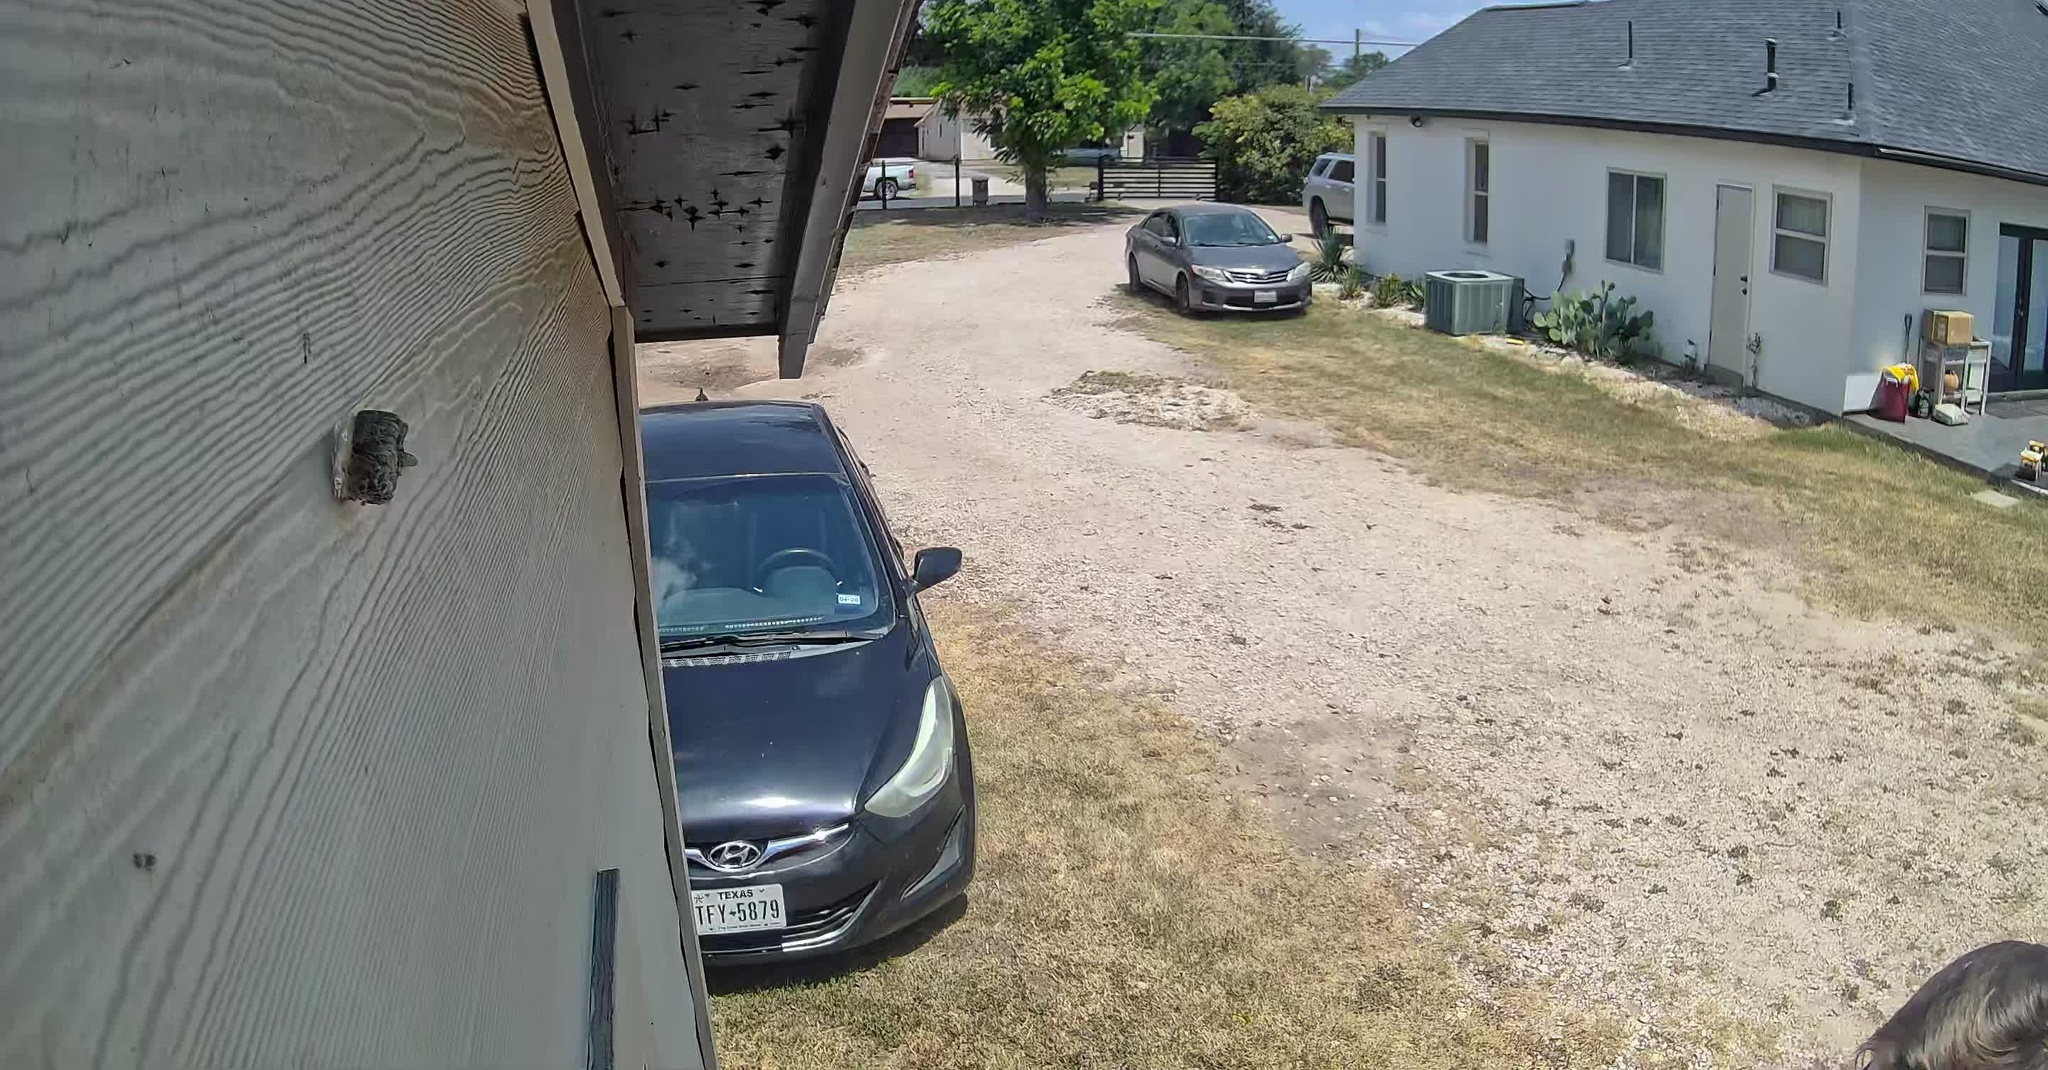

In [ ]:
# Get image from stream
generate_image_command = {"command": "sdm.devices.commands.generate_image_from_rtsp_stream",
                          "params": {
                              "rtsp_url": generate_stream_output.get("results", {}).get("streamUrls", "").get("rtspUrl", "")
                              }
                          }
image_1 = sdm.execute_command(device_id=out_door_cam_id, project_id=project_id, command_request=generate_image_command)

# Stop RTSP stream
stop_stream_command = {"command": "sdm.devices.commands.stop_rtsp_stream",
                       "params": {
                           "stream_extension_token": generate_stream_output.get("results", {}).get("streamExtensionToken", "")
                           }
                       }
stop_stream_output = sdm.execute_command(device_id=out_door_cam_id, project_id=project_id, command_request=stop_stream_command)

# THIS IS JUST FOR DEBUGGING
display_base64_image(image_1)

In [ ]:
# Mock reply from Gemini
print("The image shows the driveway being dry and dusty. \
The ground is dry, indicating that it has not rained today. \
Hence turning on the front and back yard sprinklers")

front_sprinkler_id = home_assistant.get_id_by_name(frontyard_sprinkler_name)
back_sprinkler_id = home_assistant.get_id_by_name(backyard_sprinkler_name)

home_assistant.toggle_device(front_sprinkler_id, 'On')
home_assistant.toggle_device(back_sprinkler_id, 'On')

The image shows the driveway being dry and dusty. The ground is dry, indicating that it has not rained today. Hence turning on the front and back yard sprinklers


{'status': 'SUCCESS'}

# Final Assertion

1. Assert that both front yard and back yard sprinklers are turned on.
2. Assert that all the relevant images are utilized.

In [ ]:
import home_assistant
import sdm

# Local variables
frontyard_sprinkler_name = "Front yard Sprinkler System"
backyard_sprinkler_name = "Back yard Sprinkler System"

# Helper functions
def are_all_images_used(expected_paths: list[str], served_type: str) -> bool:
    # Get served images
    served_image_paths = sdm.devices.commands.get_served_images()
    if served_type == "event":
        image_paths = served_image_paths.get("EVENT_IMAGES", [])
    elif served_type == "stream":
        image_paths = served_image_paths.get("STREAM_IMAGES", [])
    else:
        print("Invalid served type.")
        return False

    # Check if all expected paths are present in unique_used_paths
    return set(expected_paths).issubset(set(image_paths))

# 1. Assert that both front and back sprinklers are turned on
frontyard_sprinkler_id = home_assistant.get_id_by_name(frontyard_sprinkler_name)
backyard_sprinkler_id = home_assistant.get_id_by_name(backyard_sprinkler_name)

front_sprinkler_state = home_assistant.get_state(frontyard_sprinkler_id)
back_sprinkler_state = home_assistant.get_state(backyard_sprinkler_id)

assert front_sprinkler_state.get("state", "") == "On", "Front sprinkler is turned off, expected it to be on."
assert back_sprinkler_state.get("state", "") == "On", "Back sprinkler is turned off, expected it to be on."

# 2. Assert that all the relevant images are utilized.
# Collect expected image paths from the image map
image_map = sdm.load_image_map()
all_expected_paths = []
camera_image_entries = image_map.get("cameras", {})
event_image_entries = image_map.get("events", [])

for camera_id, image_entries in camera_image_entries.items():
    for entry in image_entries:
        if entry.get("expected") == "Yes":
            all_expected_paths.append(entry.get("image_path"))

expected_event_paths = []
for event in event_image_entries:
    expected_event_paths.append(event.get("image_path"))

expected_stream_paths = [path for path in all_expected_paths if path not in expected_event_paths]

# Assert that all relevant images are used
assert are_all_images_used(expected_event_paths, "event"), "Mismatch: Not all expected event images were used."
assert are_all_images_used(expected_stream_paths, "stream"), "Mismatch: Not all expected stream images were used."